## Imports

In [1]:
import glob
import os
import pprint

import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import losses, optimizers, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import torch

import dgl
import networkx as nx

from stellargraph import StellarGraph
from stellargraph.mapper import GraphSAGELinkGenerator, GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import EdgeSplitter, UnsupervisedSampler
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

2022-08-10 18:31:00.749131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-10 18:31:00.749166: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Using backend: pytorch
2022-08-10 18:31:03.170471: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-10 18:31:03.170531: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (artem-VLT-WX0): /proc/driver/nvidia/version does not exist
2022-08-10 18:31:03.172021: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-crit

In [2]:
DATA_DIR = "data"
INTERIM_DIR = "interim"
MODEL = "models"

In [3]:
pp = pprint.PrettyPrinter(indent=4)

## GAT

GAT, which stands for Graph Attention is a concept, presented in <a href="https://arxiv.org/abs/1710.10903">a work</a>.

#### Graph preparation

Because we use stellargraph to implement this approach, we would convert the graph we used for GNN in previous approch to another representation.

In [18]:
files = os.path.join("..", DATA_DIR, INTERIM_DIR, "node_dfs_2hops", "*.csv")
file_names = glob.glob(files)
gs = []
train_test = []
labels = []
G_ = nx.Graph()
d = dict()

for x, file in enumerate(file_names):
    df = pd.read_csv(file, index_col="Unnamed: 0").drop_duplicates().astype(int)
    l = file[-5]
    labels.append(int(l))
    np_df = np.array(df)
    e = np_df[:]
    s = np_df[np_df[:, -2], 0]
    edges = []
    for s1, e1 in zip(s.tolist(), e.tolist()):
        edges.append((s1, e1[0]))
        G_.add_node(
            e1[0],
            attr=e1[:4],
            label="node",
        )
        if e1[0] == np_df[0, 0]:
            d[e1[0]] = int(l)
    
    G_.add_edges_from(edges)
node_subjects = pd.DataFrame(d.values(), index=d.keys(), columns=["mark"]).mark

In [19]:
G = StellarGraph.from_networkx(G_, node_features="attr")
# nodes = list(G.nodes())
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 17555, Edges: 17814

 Node types:
  node: [17555]
    Features: float32 vector, length 4
    Edge types: node-default->node

 Edge types:
    node-default->node: [17814]
        Weights: all 1 (default)
        Features: none


We reset our labels to form node_subjects to expand the graph we work with. Those nodes, which labels we do not exactly, we mark with "2".

In [20]:
nodes = []
labels = []
p = 0.01

for node in G.nodes():
    if node not in node_subjects.index:
        chance = np.random.random(1)
        if chance < p:
            nodes.append(node)
            labels.append(2)
    else:
        nodes.append(node)
        labels.append(node_subjects[node])
node_subjects = pd.DataFrame(labels, index=nodes, columns=["mark"]).mark

In [21]:
G = StellarGraph.from_networkx(G_.subgraph(node_subjects.index), node_features="attr")
nodes = list(G.nodes())
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 451, Edges: 319

 Node types:
  node: [451]
    Features: float32 vector, length 4
    Edge types: node-default->node

 Edge types:
    node-default->node: [319]
        Weights: all 1 (default)
        Features: none


#### Set hyperparameters:

In [22]:
epochs = 50
lr = 1e-3
loss = losses.categorical_crossentropy
optimizer=optimizers.Adam(learning_rate=lr)
patience = 20  # The number of epochs to wait before early-stop by model training

#### Prepare data for GraphSAGE model.

We split the index for train, validation and test datasets

In [23]:
train_subjects, val_subjects = model_selection.train_test_split(
    node_subjects,
    train_size=0.7,
    test_size=None,
    stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    val_subjects,
    train_size=0.9,
    test_size=None,
    stratify=val_subjects
)

We binarize the labels with standard sklearn tools.

In [24]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

We generate the sequences for our model

In [46]:
generator = FullBatchNodeGenerator(G, method="gat")

train_gen = generator.flow(train_subjects.index, train_targets)
val_gen = generator.flow(val_subjects.index, val_targets)
test_gen = generator.flow(test_subjects.index, test_targets)

In [47]:
train_subjects.value_counts()

1    151
2    117
0     47
Name: mark, dtype: int64

#### Define the GraphSAGE model itself.

We make a three-layer GAT model.

In [73]:
gat = GAT(
    layer_sizes=[4, 16, train_targets.shape[1]],
    activations=["selu", "selu", "softmax"],
    attn_heads=4,
    generator=generator,
    # in_dropout=0.1,
    # attn_dropout=0.1,
    normalize="none",
)

x_inp, predictions = gat.in_out_tensors()

In [74]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["acc"],
)

#### Train the model

Prepare logling for early-stop

In [75]:
if not os.path.isdir("logs"):
    os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc",
    patience=patience
)
mc_callback = ModelCheckpoint(
    "logs/best_model.h5",
    monitor="val_acc",
    save_best_only=True,
    save_weights_only=True
)

In [76]:
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/50
1/1 - 2s - loss: 8.3916 - acc: 0.4794 - val_loss: 8.3233 - val_acc: 0.4836
Epoch 2/50
1/1 - 0s - loss: 8.3916 - acc: 0.4794 - val_loss: 8.3233 - val_acc: 0.4836
Epoch 3/50
1/1 - 0s - loss: 8.3916 - acc: 0.4794 - val_loss: 8.3233 - val_acc: 0.4836
Epoch 4/50
1/1 - 0s - loss: 8.3916 - acc: 0.4794 - val_loss: 8.3233 - val_acc: 0.4836
Epoch 5/50
1/1 - 0s - loss: 8.3916 - acc: 0.4794 - val_loss: 8.3233 - val_acc: 0.4836
Epoch 6/50
1/1 - 0s - loss: 8.3916 - acc: 0.4794 - val_loss: 8.3233 - val_acc: 0.4836
Epoch 7/50
1/1 - 0s - loss: 8.3916 - acc: 0.4794 - val_loss: 8.3233 - val_acc: 0.4836
Epoch 8/50
1/1 - 0s - loss: 8.3916 - acc: 0.4794 - val_loss: 8.3233 - val_acc: 0.4836
Epoch 9/50
1/1 - 0s - loss: 8.3916 - acc: 0.4794 - val_loss: 8.3233 - val_acc: 0.4836
Epoch 10/50
1/1 - 0s - loss: 8.3916 - acc: 0.4794 - val_loss: 8.3233 - val_acc: 0.4836
Epoch 11/50
1/1 - 0s - loss: 8.3916 - acc: 0.4794 - val_loss: 8.3233 - val_acc: 0.4836
Epoch 12/50
1/1 - 0s - loss: 8.3916 - acc: 0.4794 - 

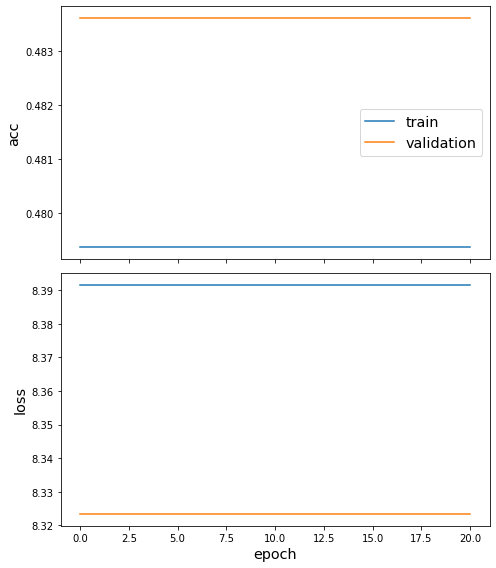

In [77]:
sg.utils.plot_history(history)

#### Evaluate model performance

In [78]:
model.load_weights("logs/best_model.h5")

In [79]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 45ms/step - loss: 8.0590 - acc: 0.5000

Test Set Metrics:
	loss: 8.0590
	acc: 0.5000


In [80]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [81]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())
node_predictions.shape

(451,)

In [82]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df[df["Predicted"] == df["True"]]["True"].value_counts()

1    216
0      1
Name: True, dtype: int64

#### Visualiztion

In [83]:
emb_layer = next(l for l in model.layers if l.name.startswith("graph_attention"))
print(
    "Embedding layer: {}, output shape {}".format(emb_layer.name, emb_layer.output_shape)
)

Embedding layer: graph_attention_sparse_33, output shape (1, 451, 16)


In [84]:
embedding_model = Model(inputs=x_inp, outputs=emb_layer.output)
emb = embedding_model.predict(all_gen)
emb.shape

(1, 451, 16)

In [85]:
X = emb.squeeze()
y = np.argmax(target_encoding.transform(node_subjects), axis=1)

In [86]:
if X.shape[1] > 2:
    transform = TSNE  # PCA
    
    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=list(G.nodes()))
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=list(G.nodes()))
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

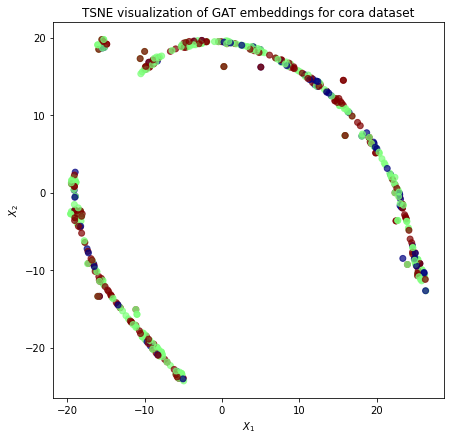

In [87]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GAT embeddings for cora dataset".format(transform.__name__)
)
plt.show()

This attempt is quite unsuccessful, maybe, due to the structure of graph, we have created (large number of connected components)